In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
def read_data_frame(file_path):
    df=pd.read_parquet(file_path)

    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda x:x.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df
    
    

In [3]:
df_train=read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73908 entries, 0 to 76517
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               73908 non-null  int64         
 1   lpep_pickup_datetime   73908 non-null  datetime64[us]
 2   lpep_dropoff_datetime  73908 non-null  datetime64[us]
 3   store_and_fwd_flag     38175 non-null  object        
 4   RatecodeID             38175 non-null  float64       
 5   PULocationID           73908 non-null  object        
 6   DOLocationID           73908 non-null  object        
 7   passenger_count        38175 non-null  float64       
 8   trip_distance          73908 non-null  float64       
 9   fare_amount            73908 non-null  float64       
 10  extra                  73908 non-null  float64       
 11  mta_tax                73908 non-null  float64       
 12  tip_amount             73908 non-null  float64       
 13  tolls_

In [5]:
'''cat_col=df_train.select_dtypes(include='object')
   num_col=df_train.select_dtypes(exclude='object')'''

"cat_col=df_train.select_dtypes(include='object')\n   num_col=df_train.select_dtypes(exclude='object')"

In [6]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


/tmp/ipykernel_25/55724668.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)


<Axes: xlabel='duration', ylabel='Density'>

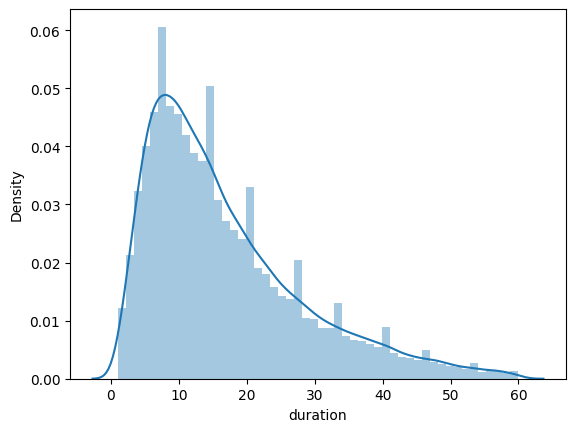

In [7]:
sns.distplot(df_train.duration)

In [8]:
df_train.duration

0         3.933333
1         8.750000
2         5.966667
3         7.083333
7         2.316667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 73908, dtype: float64

In [9]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [10]:
df_train.duration.describe(percentiles=[.95,.98,.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [11]:
cat_cols = ['PULocationID', 'DOLocationID']
num_cols = ['trip_distance']
train_dicts=df_train[cat_cols+num_cols].to_dict(orient='records')
dv=DictVectorizer()
x_train=dv.fit_transform(train_dicts)
target='duration'
y_train=df_train[target].values
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_train)
mse=mean_squared_error(y_train, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(9.838799799829626)

/tmp/ipykernel_25/1877227026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')
/tmp/ipykernel_25/1877227026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


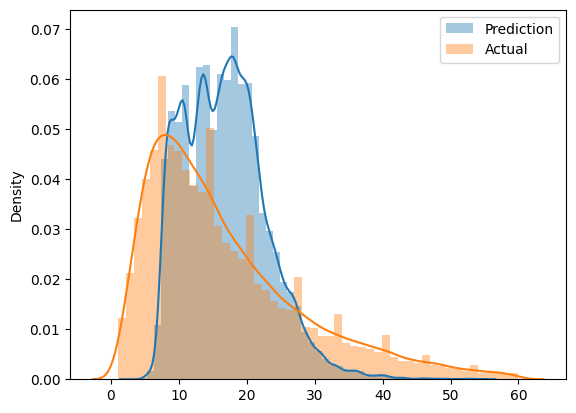

In [18]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [19]:
df_train['PU_DO']=df_train['PULocationID']+'_'+df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [22]:
cat_col=['PU_DO']
num_col=['trip_distance']
dv=DictVectorizer()
train_dicts=df_train[cat_col+num_col].to_dict(orient='records')
x_train=dv.fit_transform(train_dicts)
val_dicts = df_val[cat_col + num_col].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [23]:
target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [26]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_val)
mse=mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(7.758715208009878)

In [27]:
lr=Ridge()
lr.fit(x_train,y_train)

y_pred=lr.predict(x_val)
mse=mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(7.70373515548786)

In [30]:
import os
os.makedirs('Models',exist_ok=True)
with open('Models/rdge.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)